## Haar Cascades and Simple Face Detection

In [1]:
import cv2
import matplotlib.pyplot as plt


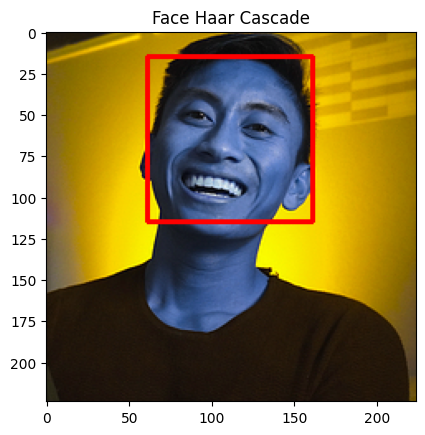

CPU times: user 515 ms, sys: 26.5 ms, total: 542 ms
Wall time: 276 ms


In [2]:
%%time

# Load pre-trained Haar cascades for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Read the image
image = cv2.imread('face2.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
    
# Displaying magnitude spectrum
plt.imshow(image)
plt.title('Face Haar Cascade')
plt.show()

## Tensorflow and SSD MobileNet v2

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np 



In [4]:
#This is to import the underlying label map for SSD-MobileNet-v2
# We pulled this ffrom the following Github link: https://gist.github.com/iitzco/3b2ee634a12f154be6e840308abfcab5 

from coco_label_map import LABEL_MAP
import matplotlib.pyplot as plt
import matplotlib.patches as patches



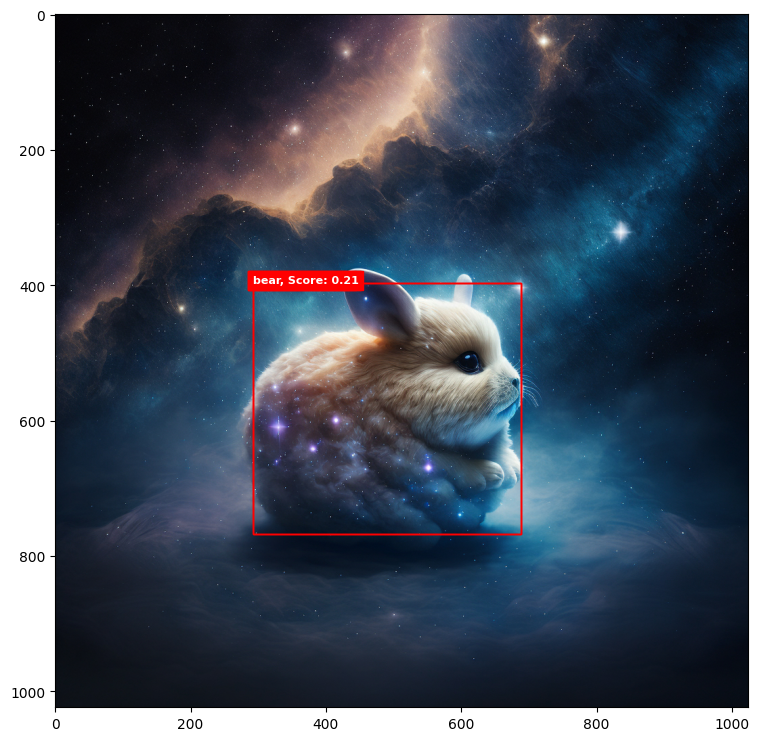

CPU times: user 7.24 s, sys: 419 ms, total: 7.66 s
Wall time: 8.04 s


In [5]:
%%time

# Load a pre-trained model
model = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1")

# Load and preprocess an image
image_np = np.array(tf.image.decode_image(tf.io.read_file('starbunnyy.jpg')))
input_tensor = tf.convert_to_tensor(image_np)
input_tensor = input_tensor[tf.newaxis, ...]

# Perform object detection
detections = model(input_tensor)

def load_image_into_numpy_array(path):
    return np.array(tf.image.decode_image(tf.io.read_file(path)))

# Function to draw the detection boxes
def draw_boxes(image_np, detections, threshold=0.2):
    im_height, im_width, _ = image_np.shape
    boxes = detections['detection_boxes'][0].numpy()
    class_names = detections['detection_classes'][0].numpy().astype(np.int32)
    scores = detections['detection_scores'][0].numpy()

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image_np)

    # Loop through each detection
    for i in range(boxes.shape[0]):
        if scores[i] > threshold:
            box = boxes[i]
            y_min, x_min, y_max, x_max = box
            (left, right, top, bottom) = (x_min * im_width, x_max * im_width, 
                                          y_min * im_height, y_max * im_height)
            width, height = right - left, bottom - top

            # Create a Rectangle patch
            rect = patches.Rectangle((left, top), width, height, linewidth=1, 
                                     edgecolor='r', facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)
            
            # Annotate class name and score, and use label map
            class_id = class_names[i]
            class_name = LABEL_MAP.get(class_id, 'N/A')
            label = f'{class_name}, Score: {scores[i]:.2f}'
            ax.text(left, top, label, color='white', backgroundcolor='red', 
                    fontsize=8, weight='bold')

    plt.show()

# Load and preprocess an image
image_path = 'starbunnyy.jpg'
image_np = load_image_into_numpy_array(image_path)
input_tensor = tf.convert_to_tensor(image_np)
input_tensor = input_tensor[tf.newaxis, ...]

# Perform object detection
detections = model(input_tensor)

# Draw boxes on the image
draw_boxes(image_np, detections)



## PyTorch & Torchvision

### Now using Faster RCNN 


In [6]:
import torch
import torchvision

import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches


/Users/sbatir/miniforge3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/sbatir/miniforge3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/sbatir/miniforge3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


bird, Score: 0.8722450137138367
bear, Score: 0.3278828561306
sports, Score: 0.12482371181249619
apple, Score: 0.07777649909257889


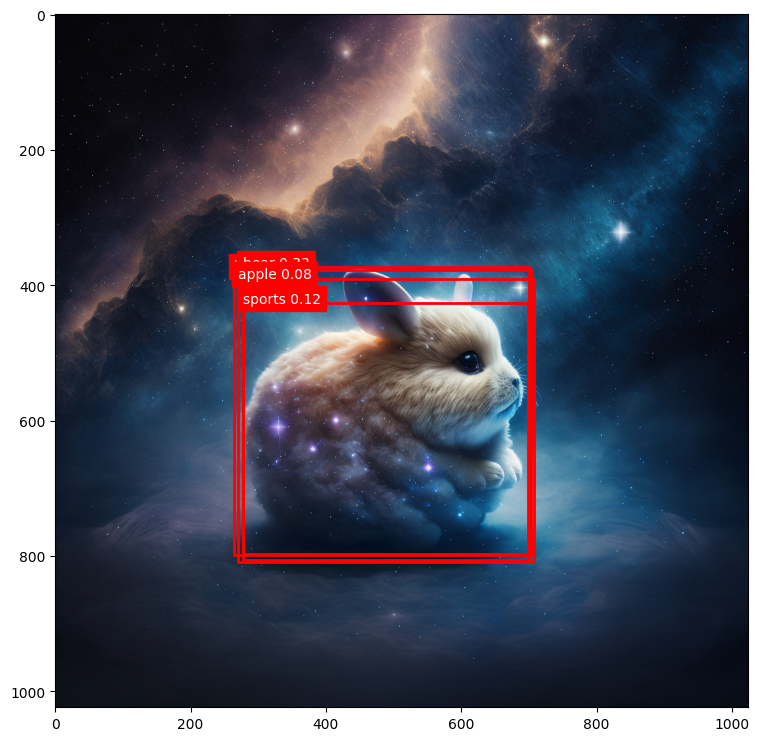

CPU times: user 2.54 s, sys: 1.02 s, total: 3.55 s
Wall time: 1.85 s


In [7]:
%%time

# Load the pre-trained model and set to evaluation mode
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Function to load and preprocess the image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([T.ToTensor()])
    image = transform(image)
    return image

# Function to visualize the predictions
def show_preds(image_np, predictions):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image_np)

    for box, label, score in zip(predictions['boxes'], predictions['labels'], predictions['scores']):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, 
                                 edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        class_name = LABEL_MAP.get(label.item(), 'N/A')
        print(f'{class_name}, Score: {score}')
        ax.text(xmin, ymin, f'{class_name} {score:.2f}', color='white', backgroundcolor='red')
    plt.show()

# Load and preprocess the image
image = load_image('starbunnyy.jpg')

# Perform object detection
with torch.no_grad():
    prediction = model([image])

# Extract predictions
predictions = {
    'boxes': prediction[0]['boxes'].detach().numpy(),
    'labels': prediction[0]['labels'].detach().numpy(),
    'scores': prediction[0]['scores'].detach().numpy()
}

# Visualize the predictions
# We use image permute to change an image tensor from [channel, height, width] - the
#default approach used by PyTorch, and switch it to [height, width, channels]
# This is a rearrangement necessary to display images correctly using show_preds
# which expects a channel-last format. 

show_preds(image.permute(1, 2, 0).numpy(), predictions)